# Comp Screening - cell painting GT (dose time) analysis
## FOR COMPLTETE (datalock) cell painting dataset
#### CK, BEM 1-19-2022_

### What this does:
- Analysis of the 2 replicates 3 doses (0.1,1, 10 uM) X 3 time points (6 hours, 24 hours, 48 hours) dataset
- For each time point
    - calculates the effect of compounds relative to DMSO (measured by Mahalanobis distance
    - calcualtes the coeficient of variation of the effects across compounds
    - Largest coef of variation at 24 hour timepoint
- For each dose in the 24 hour timepoint
    - Calcualte coef of variation of mahalanobis distances to access best dose to screen at

In [1]:
import os
import sys
import warnings
import random
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import anndata
import multiprocess as mp
from itertools import repeat
from scipy.stats import mode
from scipy.stats import fisher_exact
from sklearn.metrics import silhouette_samples, silhouette_score, auc
from sklearn.covariance import EmpiricalCovariance
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests

pd.set_option('mode.chained_assignment', None)
data_path = '../1_Data/'

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

## Define Functions

#### Mahalanobis calcs

In [2]:
def mahala_dist(adata, use_rep='X', mahala_cutoff=7, n_sample=int(1e6), assume_centered=False, num_pcs=None):
    """
    Calculates the mahalanobis disance of the pert. avg and provides a standard deviation cutoff based on DMSO null dist
    in adata using MCD robust estimator trained on DMSO + avg Pert., stores values as metadata
    """
    
    # weight PCs by variance explained
    adata.obsm['X_pca_weighted'] = np.multiply(adata.obsm['X_pca'],adata.uns['pca']['variance_ratio'])
    adata.obsm['X_pca_harmony_weighted'] = np.multiply(adata.obsm['X_pca_harmony'],adata.uns['pca']['variance_ratio'])
    
    # select data
    adata_DMSO = adata[adata.obs.Metadata_perturbation=='DMSO',:]
    adata_pert = adata[~(adata.obs.Metadata_perturbation=='DMSO'),:]
    
    if use_rep == 'X':
        X_DMSO = adata_DMSO.X
        X_pert = pd.DataFrame(adata_pert.X, 
                              index=adata_pert.obs['Metadata_perturbation'])

    elif use_rep == 'X_pca':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame(adata_pert.obsm['X_pca_weighted'][:,0:num_pcs], 
                                  index=adata_pert.obs['Metadata_perturbation'])
            
    elif use_rep == 'X_pca_harmony':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_harmony_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame(adata_pert.obsm['X_pca_harmony_weighted'][:,0:num_pcs], 
                                  index=adata_pert.obs['Metadata_perturbation'])
    
    else:
        print('use_rep is not valid option')
        return
    
    # average by perturbation
    X_avg_pert = X_pert.groupby('Metadata_perturbation').mean()

    # fit covariance estimator to control + avg. pert. sample
    cov = EmpiricalCovariance(assume_centered=assume_centered).fit(X_DMSO)
    
    # calclute perturbation mahalanois distances
    if assume_centered:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert))
    else:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert-cov.location_))
    
    # sample DMSO null distribution
    n_rep = mode(X_pert.iloc[:,0].groupby('Metadata_perturbation').count()).mode[0]
    n_DMSO = len(X_DMSO)
    DMSO_null = np.mean(X_DMSO[np.random.randint(0,n_DMSO,size=(n_sample,n_rep))], axis=1)
    
    #calc DMSO null mahalanobis
    if assume_centered:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null))
    else:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null-cov.location_))
            
    # build pert table
    # get cutoff based on multiples of DMSO stdev
    mahala_cutoff = (mahala_cutoff*np.std(DMSO_mahal))+np.mean(DMSO_mahal)
    
    mahala_table = pd.DataFrame(pert_mahal, 
                                index=X_avg_pert.index,
                                columns=['mahalanobis'])
    mahala_table['signif_mahala'] = (pert_mahal > mahala_cutoff)
    mahala_table.reset_index(inplace=True)
    
    # add back to adata
    merge_table = pd.DataFrame(adata.obs.Metadata_perturbation).merge(mahala_table, 
                                                                      on='Metadata_perturbation', 
                                                                      how='left')
    merge_table = merge_table.set_index('Metadata_perturbation').reset_index(drop=True)
    

    adata.obs['mahalanobis'] = merge_table.mahalanobis.values
    adata.obs['signif_mahala'] = merge_table.signif_mahala.values
    
    # make mahala table for plotting    
    dmso_table = pd.DataFrame(np.random.choice(DMSO_mahal, size=n_DMSO*2, replace=False),
                              columns=['mahalanobis'])
    dmso_table['Metadata_perturbation'] = 'DMSO'
    dmso_table['signif_mahala'] = 'DMSO'
    
    mahala_table = pd.concat([mahala_table, dmso_table])
    
    return adata, mahala_table

## Analysis

### Load in anndata

In [3]:
# PCA harmony data
DT = anndata.read_h5ad(data_path+'09272021_PCH_rd_DT_table.h5ad')

# filter to only ground truth data of 316 compounds
DT = DT[~DT.obs.Metadata_perturbation.isin(['Auranofin', 'Bortezomib', 'Paclitaxel (Taxol)', 'Vincristine Sulfate']),:]
DT = DT[DT.obs.Metadata_run.isin(['GT_run1_batch1', 'GT_run1_batch2']),:]

/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Determine num_PCs, neighbors, UMAP

2022-05-25 08:46:43,739 - harmonypy - INFO - Iteration 1 of 25
2022-05-25 08:46:45,152 - harmonypy - INFO - Iteration 2 of 25
2022-05-25 08:46:46,566 - harmonypy - INFO - Iteration 3 of 25
2022-05-25 08:46:47,894 - harmonypy - INFO - Iteration 4 of 25
2022-05-25 08:46:49,286 - harmonypy - INFO - Iteration 5 of 25
2022-05-25 08:46:50,843 - harmonypy - INFO - Iteration 6 of 25
2022-05-25 08:46:52,351 - harmonypy - INFO - Iteration 7 of 25
2022-05-25 08:46:53,877 - harmonypy - INFO - Iteration 8 of 25
2022-05-25 08:46:55,587 - harmonypy - INFO - Iteration 9 of 25
2022-05-25 08:46:57,299 - harmonypy - INFO - Iteration 10 of 25
2022-05-25 08:46:58,848 - harmonypy - INFO - Iteration 11 of 25
2022-05-25 08:47:00,408 - harmonypy - INFO - Iteration 12 of 25
2022-05-25 08:47:02,018 - harmonypy - INFO - Converged after 12 iterations


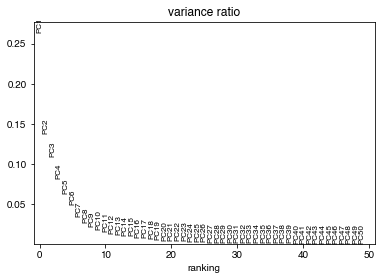

90% of variance explained by 20 PCs


In [4]:
# recalc PC's for dataset
sc.pp.pca(DT)

sc.external.pp.harmony_integrate(DT, 'Metadata_run', max_iter_harmony = 25)

# get num of PCs to use (up to 90% var explained)
sc.pl.pca_variance_ratio(DT, n_pcs = 50, log=False)
num_pcs = sum(np.cumsum(DT.uns['pca']['variance_ratio']) < 0.9)+1

print('90% of variance explained by '+str(num_pcs)+' PCs')

### Determine Signif Pertrubs by Mahalnobis Dist

In [5]:
DT.obs['Metadata_time_conc'] = DT.obs.Metadata_time_hr.map(str)+"_"+DT.obs.Metadata_conc_uM.map(str)

In [6]:
mahala_table = pd.DataFrame()

for tc in list(set(DT.obs.Metadata_time_conc)):
    
    DT_tc = DT[DT.obs.Metadata_time_conc == tc,:]
    mahala_table_tc = mahala_dist(DT_tc, mahala_cutoff=2,
                                  use_rep='X_pca_harmony',
                                  num_pcs=num_pcs)[1]
    
    mahala_table_tc['dose']= list(set(DT_tc.obs.Metadata_conc_uM))[0]
    mahala_table_tc['time']= list(set(DT_tc.obs.Metadata_time_hr))[0]
    
    mahala_table = pd.concat([mahala_table, mahala_table_tc])

/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence 

In [7]:
mahala_table

,Metadata_perturbation,mahalanobis,signif_mahala,dose,time
0,4-Aminosalicylic Acid,21.376626,True,10.0,24
1,(S)-Timolol Maleate,8.811748,False,10.0,24
2,(±) Isoproterenol,10.902448,True,10.0,24
3,(±)-Atenolol,13.430576,True,10.0,24
4,Acetylcholine Chloride,11.761060,True,10.0,24
...,...,...,...,...,...
123,DMSO,4.306024,DMSO,1.0,6
124,DMSO,5.397362,DMSO,1.0,6
125,DMSO,4.687648,DMSO,1.0,6
126,DMSO,4.155460,DMSO,1.0,6


#### Calculate Area Under Curve (auc) for mahala-dose realtionships @ each time

In [8]:
auc_table = mahala_table.sort_values(by=['dose'])

auc_DMSO = auc_table.loc[auc_table.Metadata_perturbation=='DMSO',:]
auc_DMSO = auc_DMSO.groupby(['time','dose']).mean()

auc_table = auc_table.loc[auc_table.Metadata_perturbation!='DMSO',:]
mahala_pert_table = auc_table

auc_grouped =  auc_table.groupby(['time','Metadata_perturbation'])

In [16]:
xx

array([ 0.1,  1. , 10. ])

In [17]:
yy

array([ 5.72790723, 10.9997723 , 15.29516069])

In [9]:
auc_table = list()
for t in [6,24,48]:
    xx=auc_DMSO.loc[t].index.values
    yy=auc_DMSO.loc[t].mahalanobis.values
    auc_table.append([t,auc(xx,yy)])

auc_DMSO = pd.DataFrame(auc_table)
auc_DMSO.columns = ['time', 'auc']
auc_DMSO['log_auc'] = np.log10(auc_DMSO.auc)

In [10]:
auc_DMSO

,time,auc,log_auc
0,6,49.493291,1.694546
1,24,62.285939,1.794390
2,48,68.559480,1.836068


In [11]:
auc_table = list()
for name, group in auc_grouped:
    if len(group)==3:
        xx=group.dose.values 
        yy=group.mahalanobis.values
        auc_table.append([name[0],name[1],auc(xx,yy)])

In [12]:
auc_table = pd.DataFrame(auc_table)
auc_table.columns = ['time', 'perturbation', 'auc']

In [13]:
auc_table

,time,perturbation,auc
0,6,(S)-Timolol Maleate,59.046233
1,6,(±) Isoproterenol,81.196049
2,6,(±)-Atenolol,90.286901
3,6,4-Aminosalicylic Acid,96.168631
4,6,Acetylcholine Chloride,75.394582
...,...,...,...
925,48,Zidovudine (3'-Azido-3'-Deoxythymidine),146.423181
926,48,Zileuton,74.046438
927,48,Zoledronic Acid Monohydrate,123.707916
928,48,Zolmitriptan,144.016636


In [46]:
x = np.log(mahala_table['mahalanobis'].loc[mahala_table.time==6])
np.std(x)/np.mean(x)

0.1771924677275529

In [48]:
x = np.log(mahala_table['mahalanobis'].loc[mahala_table.time==24])
np.std(x)/np.mean(x)

0.258910999344151

In [50]:
x = np.log(mahala_table['mahalanobis'].loc[mahala_table.time==48])
np.std(x)/np.mean(x)

0.24325859853784548

In [52]:
mahala_table['log_mahala'] = np.log(mahala_table['mahalanobis'])

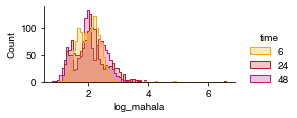

In [62]:
#plot AUC by time
g = sns.displot(
    mahala_table, x='log_mahala', log_scale=False,
    hue="time", kind='hist',
    element="step",
    height=1.75, aspect=2, palette=['orange','firebrick', 'mediumvioletred']);

g.savefig("figures/DT_mahala_hist_by_time.pdf");

#### Within 24 hours determine dose-auc correlations

In [18]:
mahala_pert_table_24 = mahala_pert_table.loc[mahala_pert_table.time == 24,:].drop(['signif_mahala', 'time'], axis=1)
auc_table_24 = auc_table.loc[auc_table.time == 24,:].drop(['time'], axis=1)

In [40]:
x = np.log(mahala_pert_table_24['mahalanobis'].loc[mahala_pert_table_24.dose==0.1])
np.std(x)/np.mean(x)

0.15652248844273967

In [41]:
x = np.log(mahala_pert_table_24['mahalanobis'].loc[mahala_pert_table_24.dose==1.0])
np.std(x)/np.mean(x)

0.1571539533677682

In [42]:
x = np.log(mahala_pert_table_24['mahalanobis'].loc[mahala_pert_table_24.dose==10])
np.std(x)/np.mean(x)

0.15045144557216505

In [56]:
mahala_pert_table_24['log_mahala'] = np.log(mahala_pert_table_24['mahalanobis'])

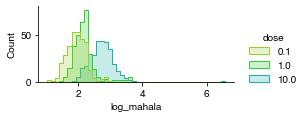

In [61]:
g = sns.displot(
    mahala_pert_table_24, x='log_mahala', log_scale=False,
    hue="dose", kind='hist',
    element="step",
    height=1.75, aspect=2, palette=['yellowgreen','limegreen','lightseagreen']);
g.savefig("figures/DT_log_mahala_24.pdf");